## Introduction

In this week's tutorial we will switch from the regression setting to doing __classification__.  
Therefore we will introduce __decision trees__ and use them to classify credit grants. Additionally we will look at methods to prevent __overfitting__ and metrics to evaluate our classification output.  
Last but not least we will look at possible pitfalls when using certain metrics.

In [1]:
# Imports
import numpy as np
import random
# Seed
np.random.seed(42)  # Set seed for NumPy
random.seed(42) # Set seed for random module

In [2]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/kbrennig/MODS_WS24_25/refs/heads/main/data/MicroCredit.csv")
data.head()

,ID,Decision,Build_Selfcon,Tier,Accommodation_Class,Loan_Type,Gender,Employment_Type,Doc_Proof_Inc,Marital_Status,...,LoanReq,Term,Dwnpay,BankSave,CalcEmi,IIR,IAR,FOIR,LTV,LVR
0,FBD-E2B0-588300,1,Self Contruction,2,Non_Rented,Home_Loan,Female,Salaried,N,Married,...,780000,180,670000,0,12004.230470,34.999797,45.000114,34.999797,80.000000,54.000000
1,GUJ-A79X-831476,0,Self Contruction,1,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,800000,180,470000,0,12312.030270,49.248121,75.533928,49.248121,62.992126,62.992126
2,SHB-947O-759226,1,Self Contruction,3,Rented,Home_Loan,Female,Salaried,N,Married,...,480000,120,120000,300000,8342.290039,41.999144,79.998946,41.999144,78.999992,80.000000
3,SHB-7S3I-679761,1,Self Contruction,3,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,300000,180,95000,0,4617.009766,30.999126,84.996498,30.999126,20.000000,76.000000
4,VAD-BPKZ-551476,0,Self Contruction,2,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,1000000,180,375000,0,15390.040040,45.000117,57.999020,45.000117,73.000001,73.000000



## Explore data

First let's have a look at the raw data.

*Run the code below.*

In [3]:
print(data.describe())
print(data.dtypes)

          Decision         Tier       eom_25     OldEmi_d   BankSave_d  \
count  1256.000000  1256.000000  1256.000000  1256.000000  1256.000000   
mean      0.799363     1.980096     0.216561     0.132962     0.118631   
std       0.400636     0.793651     0.412065     0.339669     0.323482   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     0.000000     0.000000     0.000000   
50%       1.000000     2.000000     0.000000     0.000000     0.000000   
75%       1.000000     3.000000     0.000000     0.000000     0.000000   
max       1.000000     3.000000     1.000000     1.000000     1.000000   

               Age       YrsAdd       YrsJob         Expen         TotInc  \
count  1256.000000  1256.000000  1256.000000   1256.000000    1256.000000   
mean     37.726115     9.933917    10.883758  11946.937102   29911.050955   
std       8.458466    10.575304     7.974213   7390.216194   18748.496342   
min      22.000000     0.

### Create training and test sets

We create a 80-20 training and test set.

*Run the code below.*

In [4]:
from sklearn.model_selection import train_test_split

# Dropping ID column
data = data.drop(columns="ID")

data_training, data_test = train_test_split(data, test_size=0.2, random_state=42)

## Transform data

### Transform variables

To deal with categorical variables in the decision tree we need to dummy encode the variables.

*Run the code below.*

In [5]:
from sklearn.preprocessing import OneHotEncoder
# Dummy encoding / One-hot encoding

categorical_columns = [
    "Tier",
    "Build_Selfcon",
    "Accommodation_Class",
    "Loan_Type",
    "Gender",
    "Employment_Type",
    "Doc_Proof_Inc",
    "Marital_Status",
    "Employer_Type",
    "Education_Class",
    "Mode_of_origin_class"
]

# Creating the OneHotEncoder object
encoder = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)

# Fit and transform the training data
encoded_training = encoder.fit_transform(data_training.loc[:,categorical_columns])
# Create a DataFrame with the encoded variables
encoded_training_df = pd.DataFrame(encoded_training, columns=encoder.get_feature_names_out(categorical_columns))
# Join the encoded variables to the original DataFrame and remove the original columns
data_training = data_training.reset_index(drop=True).join(encoded_training_df).drop(columns=categorical_columns)
X_train = data_training.drop(columns="Decision")
y_train = data_training["Decision"]


# Transform the test data
encoded_test = encoder.transform(data_test.loc[:,categorical_columns])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))
data_test = data_test.reset_index(drop=True).join(encoded_test_df).drop(columns=categorical_columns)
X_test = data_test.drop(columns="Decision")
y_test = data_test["Decision"]

## Classification Tree

### Grow classification tree on training data

We use the `DecisionTreeClassifier` object to create a classification tree and use the `fit` function to fit it to our training data.
The fit function takes all columns of the `X_train` dataset as the independent variables to predict the outcome.

*Run the code below.*

In [6]:
from sklearn.tree import DecisionTreeClassifier
model_01 = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

### Controlled tree

As stated in the lecture, one potential drawback of decision trees is its tendency to easily __overfit__ if the tree size isn't controlled. Overfitting describes the issue of machine learning algorithms to tailor models to the training data, at the expense of generalization to previously unseen data points.  

One solution to this problem can be to prevent the tree from growing to big by specifying certain parameters.

The most commonly used parameters are:  

* __min_samples_split:__ the minimum number of observations that must exist in a node in order for a split to be attempted.  
* __min_samples_leaf:__ The minimum number of observations in any terminal node (leaf).  
* __max_depth:__ The maximum depth of any node of the final tree, with the root node counted as depth 0.  

*Run the code below.*

In [7]:
model_02 = DecisionTreeClassifier(min_samples_split=60, min_samples_leaf=20, max_depth=5, random_state=42).fit(X_train, y_train)

### Pruning

Another option is called __pruning__ and it cuts off insignificant parts of the tree. To achieve this we simply specify the the parameter `ccp_alpha`. It is a complexity parameter, which defines a threshold for any split to be kept in the resulting tree. Roughly speaking it is the minimum improvement of model performance an additional split needs to provide. There are multiple other ways to prune a decision tree.

*Run the code below.*

In [8]:
model_03 = DecisionTreeClassifier(ccp_alpha=0.01, random_state=42).fit(X_train, y_train)

### Print trees

*Run the code below.*

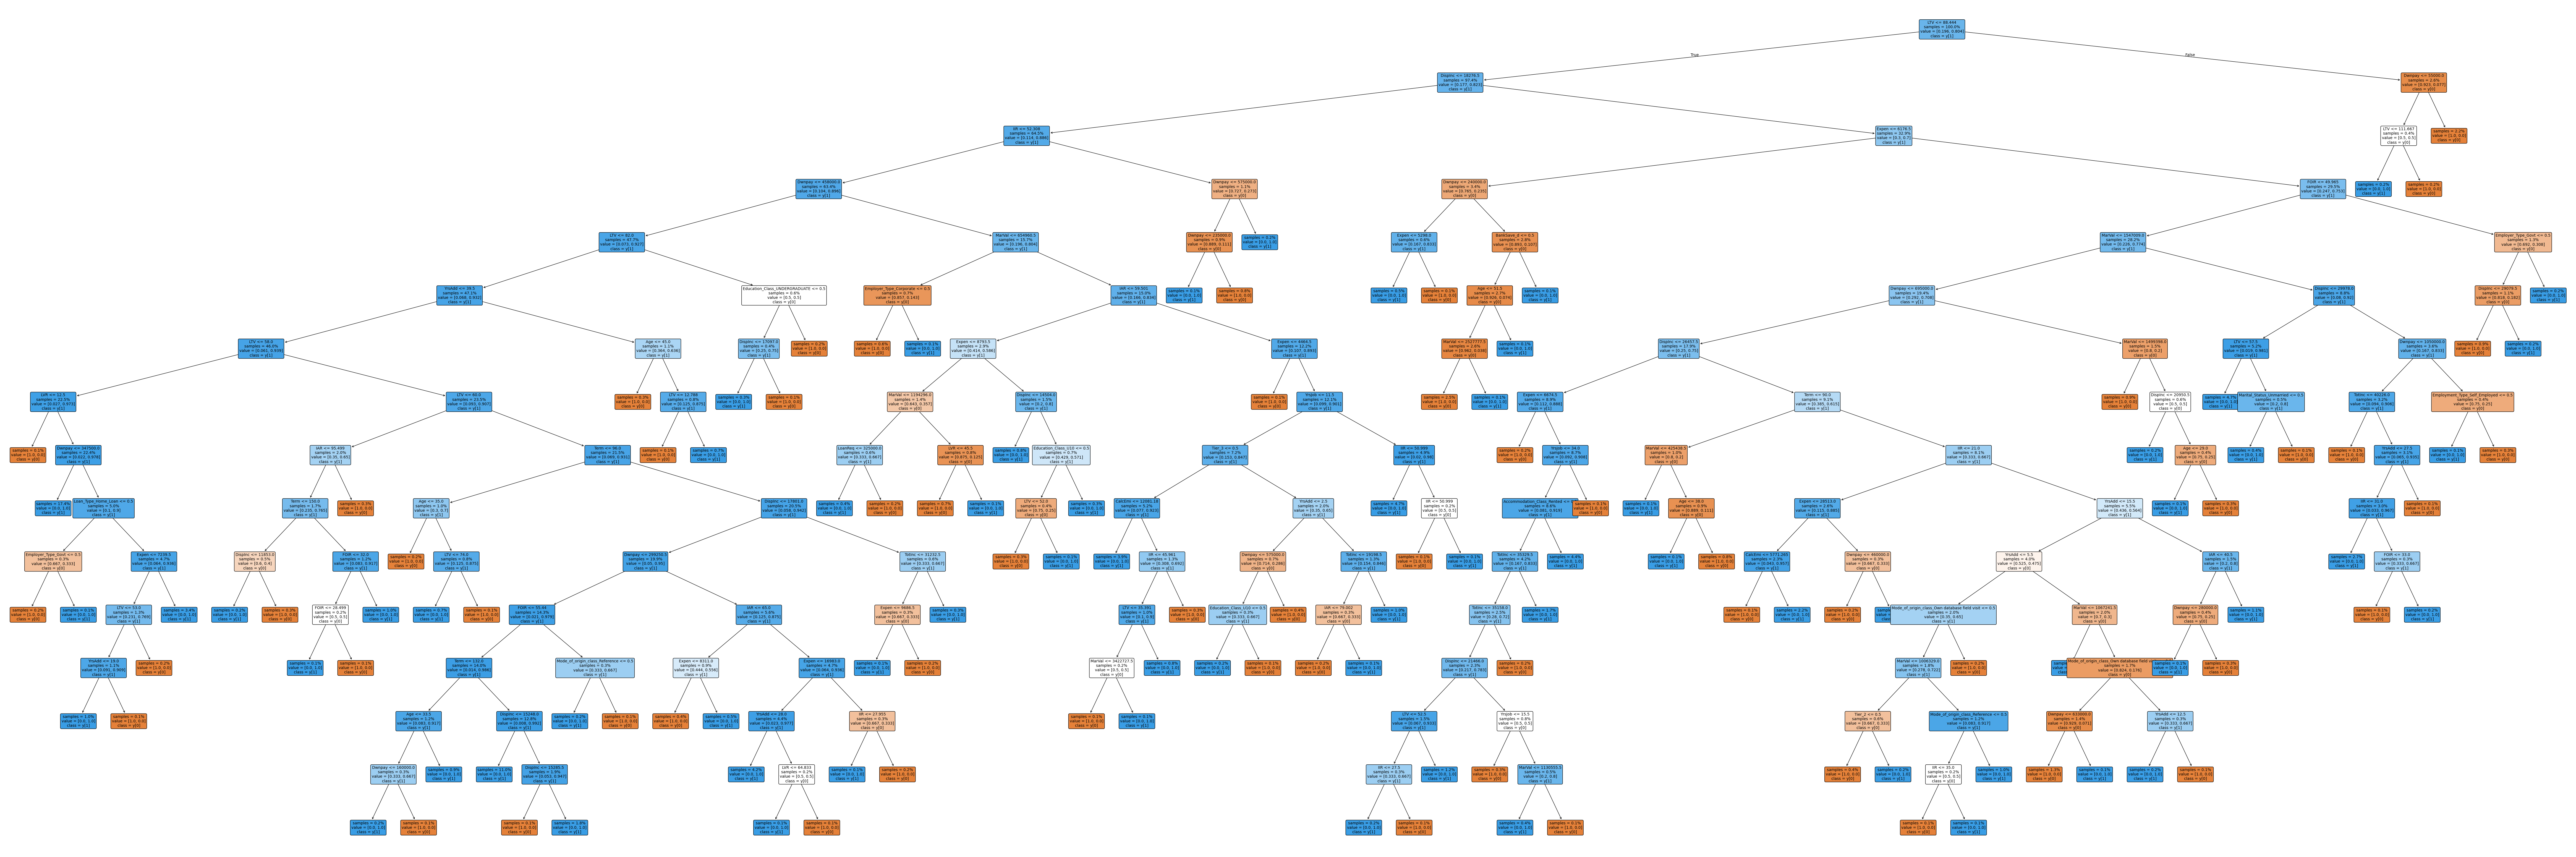

In [9]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(120,40))
# Plotting the tree
# You can click on the plotted tree to zoom in and out.
plot_tree(model_01, feature_names=X_train.columns, impurity=False, filled=True, rounded=True, proportion=True, class_names=True, fontsize=10)
plt.show()

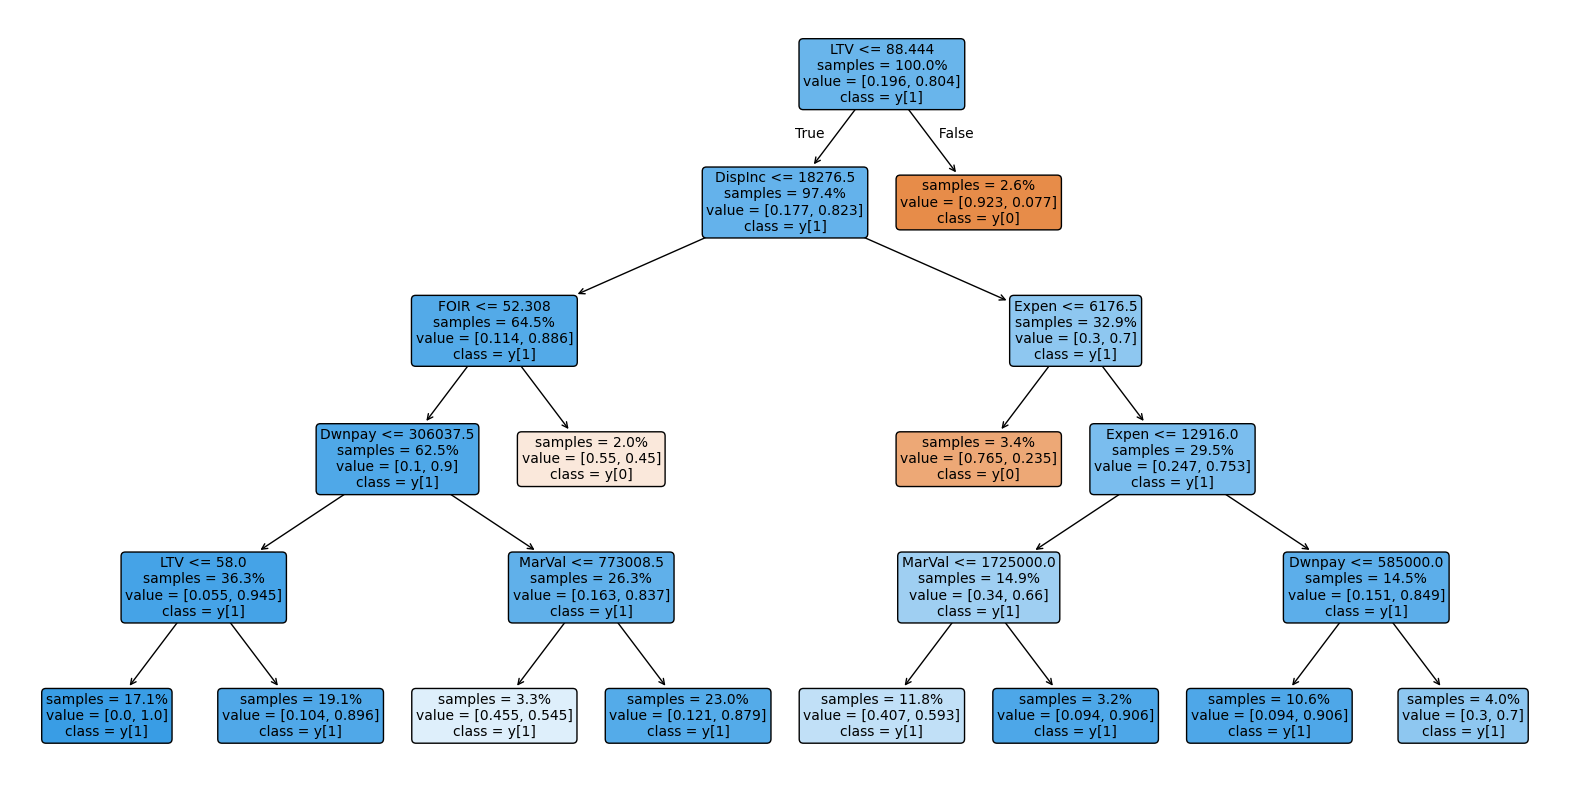

In [10]:
plt.figure(figsize=(20,10))
plot_tree(model_02, feature_names=X_train.columns, impurity=False, filled=True, rounded=True, proportion=True, class_names=True, fontsize=10)
plt.show()

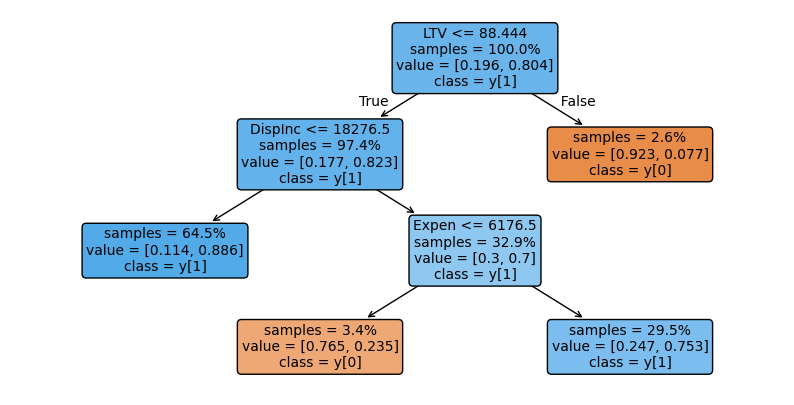

In [11]:
plt.figure(figsize=(10,5))
plot_tree(model_03, feature_names=X_train.columns, impurity=False, filled=True, rounded=True, proportion=True, class_names=True, fontsize=10)
plt.show()

## Evaluation

### Model_01

#### Make predictions on test set

Since we are doing classification this time, our evaluation is a little bit different compared to the last weeks.  

Instead of predicting a numerical outcome variable we are now predicting probabilities which are then transformed into a binary label. In the `where(predictions_test_01[:,1] > 0.5, 1, 0)` statement we can see that we set the threshold at 0.5, so if the predicted probability for a granted credit is greater then 0.5 we are labeling it as granted and otherwise as rejected (0).

You can think about how adjusting the threshold up or down would influence the outcome.


*Run the code below.*

In [ ]:
predictions_test_01 = model_01.predict_proba(X_test)
predictions_test_01_binary = np.where(predictions_test_01[:,1] > 0.5, 1, 0)

#### Calculate the resulting accuracy and the confusion matrix

Since we switched from regression to classification we are also using different evaluation metrics. The metric being calculated is the __accuracy__ which denotes how many of our predictions were correct. In addition to the accuracy we can also print a so called __confusion matrix__ which enables a more detailed interpretation of the errors we made.

There are two possible errors in a binary classification setting:

1. __False Positives (FP):__ The ground truth label is negative (0) but we predict it to be positive (1).
2. __False Negatives (FN):__ The ground truth label is positive (1) but we predict it to be negative (0).

*Run the code below.*

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the accuracy of the model
accuracy_model_01 = accuracy_score(y_test, predictions_test_01_binary)
print(accuracy_model_01)

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions_test_01_binary)

After looking at the confusion matrix we can see that out of the 252 instances that we have in our test set, 197 are positive and 55 are negative. What does that mean for our model evaluation?  
Since four out of five credits were granted, we would achieve an accuracy of 80% by simply predicting positive (1) for every instance. This problem is mainly due to the fact that we have an __unbalanced dataset__, meaning that one class has a lot more instances than the other.   

There are different ways of dealing with this issue. We could for example choose an evaluation metric that takes this imbalance into consideration or we could even adjust our dataset by using methods like __under- or oversampling__.

### Model_02

#### Make predictions on test set and calculate the accuracy and the confusion matrix

We can repeat the calculations for the second model.


In [ ]:
predictions_test_02 = model_02.predict_proba(X_test)
predictions_test_02_binary = np.where(predictions_test_02[:,1] > 0.5, 1, 0)

# Calculate the accuracy of the model
accuracy_model_02 = accuracy_score(y_test, predictions_test_02_binary)
print(accuracy_model_02)

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions_test_02_binary)

### Model_03

#### Make predictions on test set and calculate evaluation metrics

*Adapt the code and output the confusion matrix created by the third model (model_03) on the test set*

*Write your code below.*

In [ ]:
# Enter your code here

## ROC and Auc

![ROC_Curve](https://raw.githubusercontent.com/kbrennig/MODS_WS24_25/refs/heads/main/Week_6_exercise/images/ROC_Curve.png)
<br>
Source: Provost & Fawcett (2013)


Another evaluation metric for classification tasks is the __Area under the curve (AUC)__. The AUC is calculated using the __Receiver operating characteristic (ROC)__ curve which is obtained by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

### Plot ROC curve and calculate AUC on test set  

*Run the code below.*

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Calculate and Print the AUC score
auc_score = roc_auc_score(y_test, predictions_test_01[:,1])
print("AUC Score:", auc_score)

#plot ROC curve
RocCurveDisplay.from_predictions(y_test, predictions_test_01[:,1], plot_chance_level=True)

*Adapt the code and calculate the AUC of the second model (model_02) on the test data*

*Write your code below.*

AUC Score: 0.6571758191047532


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

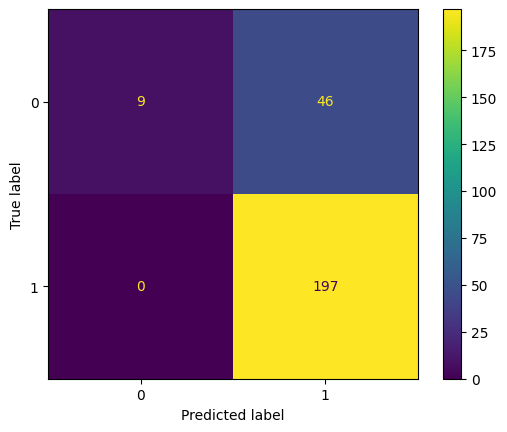

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_auc_score

predictions_test_03 = model_03.predict_proba(X_test)[:, 1]
predictions_test_03_binary = np.where(predictions_test_03 > 0.5, 1, 0)

ConfusionMatrixDisplay.from_predictions(y_test, predictions_test_03_binary)

auc_score = roc_auc_score(y_test, predictions_test_03)
print("AUC Score:", auc_score)

RocCurveDisplay.from_predictions(y_test, predictions_test_03, plot_chance_level=True)

## Summary

So to sum it up let us have a look what we did in this week's tutorial:

1. we learned how to use __decision trees__ to predict a __categorical output__ variable.
2. after that, we had a look at two methods that can be used to reduce __overfitting__.
3. finally we looked at __metrics__ to evaluate our classification output and how to avoid pitfalls when the data is __imbalanced__.



*You can use the cell below to build and evaluate different models*

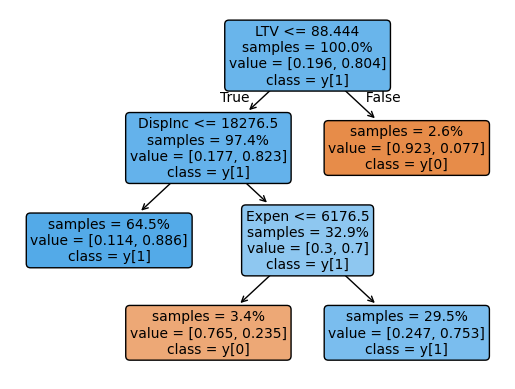

<Figure size 12000x4000 with 0 Axes>

In [31]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
model_01_1 = DecisionTreeClassifier(ccp_alpha=0.005,random_state=42).fit(X_train, y_train)
model_01_2 = DecisionTreeClassifier(ccp_alpha=0.009,random_state=42).fit(X_train, y_train)
model_01_3 = DecisionTreeClassifier(ccp_alpha=0.01,random_state=42).fit(X_train, y_train)
model_01_4 = DecisionTreeClassifier(ccp_alpha=0.8,random_state=42).fit(X_train, y_train)

plot_tree(model_01_3, feature_names=X_train.columns, impurity=False, filled=True, rounded=True, proportion=True, class_names=True, fontsize=10)
plt.figure(figsize=(120,40))
plt.show()
